<a href="https://www.kaggle.com/code/osmanacar/online-retail-cltv-prediction?scriptVersionId=187676879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Business Problem**

A company wants to segment its customers based on their purchase history information.

The aim is to predict how much revenue customers will bring to the company in their future orders.

**Variables**

* InvoiceNo: Unique invoice number. If includes C, invoice were cancelled
* StockCode: Unique product code
* Description: Name of product
* Quantity: Number of product
* InvoiceDate: Invoice date that was purchased
* UnitPrice: Cost of product
* CustomerID: Unique customer number
* Country: Country name that customer lives in

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
!pip install lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.3 MB/s eta 0:00:00


In [2]:
df_ = pd.read_excel("/kaggle/input/online-retail/online_retail_II.xlsx")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


In [3]:
# For outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [4]:
# Cleaning some unnecessary values from data

df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[~df["StockCode"].str.contains("POST", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,406926.0000,11.9227,1.0000,2.0000,5.0000,12.0000,358.5000,28.7485
InvoiceDate,406926,2010-07-01 09:58:01.902655744,2009-12-01 07:45:00,2010-03-26 14:01:00,2010-07-09 15:31:00,2010-10-14 17:09:00,2010-12-09 20:01:00,NaN
Price,406926.0000,2.9644,0.0010,1.2500,1.9500,3.7500,31.4400,3.0573
Customer ID,406926.0000,15373.4599,12346.0000,14006.0000,15325.0000,16814.0000,18287.0000,1677.2695


In [6]:
# Lifetime Data Structure Preparing

df["TotalPrice"] = df["Quantity"] * df["Price"]

today_date = dt.datetime(2011, 12, 11)

cltv_df = df.groupby("Customer ID").agg({
    "InvoiceDate": [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                    lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
    "Invoice": lambda Invoice: Invoice.nunique(),
    "TotalPrice": lambda TotalPrice: TotalPrice.sum()
})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,196,726,11,372.8600
12347.0000,37,405,2,1323.3200
12348.0000,0,439,1,221.1600
12349.0000,181,590,2,2207.1000
12351.0000,0,376,1,300.9300


In [7]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df = cltv_df[(cltv_df["frequency"] > 1)]

cltv_df["recency"] = cltv_df["recency"] / 7 # Weekly

cltv_df["T"] = cltv_df["T"] / 7  # Weekly - Tenure value

cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,28.0000,103.7143,11,33.8964
12347.0000,5.2857,57.8571,2,661.6600
12349.0000,25.8571,84.2857,2,1103.5500
12352.0000,2.2857,56.1429,2,171.9000
12356.0000,6.2857,60.7143,3,1042.0833


In [8]:
# BG-NBD Model

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2888 subjects, a: 1.93, alpha: 9.56, b: 6.27, r: 2.23>

In [9]:
# Customer who made the most purchases in a week
bgf.conditional_expected_number_of_purchases_up_to_time(1, cltv_df["frequency"],
                                                        cltv_df["recency"],
                                                        cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
15989.0000   0.0075
16720.0000   0.0072
14119.0000   0.0072
16204.0000   0.0071
17591.0000   0.0071
15169.0000   0.0070
17193.0000   0.0070
17251.0000   0.0069
17411.0000   0.0069
17530.0000   0.0068
dtype: float64

In [10]:
# just for BG-NBD model
bgf.predict(1, cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
15989.0000   0.0075
16720.0000   0.0072
14119.0000   0.0072
16204.0000   0.0071
17591.0000   0.0071
15169.0000   0.0070
17193.0000   0.0070
17251.0000   0.0069
17411.0000   0.0069
17530.0000   0.0068
dtype: float64

In [11]:
# Customer who made the most purchases in a week
cltv_df["expected_puch_1_week"] = bgf.predict(1, cltv_df["frequency"],
                                              cltv_df["recency"],
                                              cltv_df["T"])

# Customer who made the most purchases in a month
cltv_df["expected_puch_1_month"] = bgf.predict(4, cltv_df["frequency"],
                                               cltv_df["recency"],
                                               cltv_df["T"])

# Customer who made the most purchases in 3 month
cltv_df["expected_purc_3_month"] = bgf.predict(12, cltv_df["frequency"],
                                               cltv_df["recency"],
                                               cltv_df["T"])

cltv_df.head(10)

,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month,expected_purc_3_month
Customer ID,,,,,,,
12346.0000,28.0000,103.7143,11,33.8964,0.0000,0.0000,0.0000
12347.0000,5.2857,57.8571,2,661.6600,0.0004,0.0015,0.0043
12349.0000,25.8571,84.2857,2,1103.5500,0.0026,0.0101,0.0292
12352.0000,2.2857,56.1429,2,171.9000,0.0002,0.0007,0.0019
12356.0000,6.2857,60.7143,3,1042.0833,0.0001,0.0005,0.0014
12358.0000,50.8571,104.5714,3,839.6700,0.0061,0.0239,0.0693
12359.0000,44.0000,105.0000,6,421.0567,0.0008,0.0031,0.0089
12360.0000,37.5714,93.7143,3,436.9433,0.0033,0.0131,0.0377
12361.0000,31.4286,97.5714,3,92.1167,0.0013,0.0052,0.0151


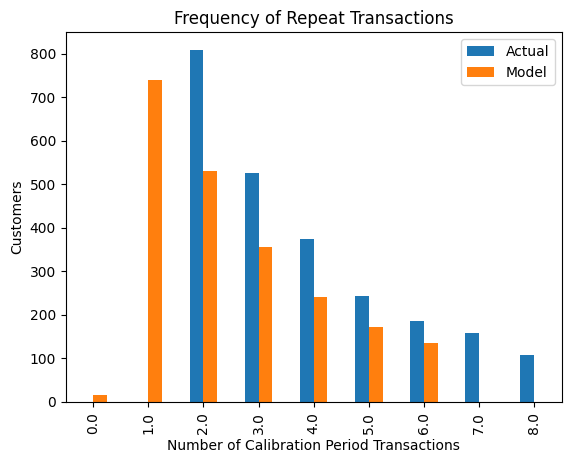

In [12]:
plot_period_transactions(bgf)
plt.show()

In [13]:
# Gamma-Gamma Model

ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df["frequency"], cltv_df["monetary"])

<lifetimes.GammaGammaFitter: fitted with 2888 subjects, p: 3.79, q: 0.34, v: 3.73>

In [14]:
ggf.conditional_expected_average_profit(
    cltv_df["frequency"],
    cltv_df["monetary"]
).head(10)

Customer ID
12346.0000     34.7848
12347.0000    726.6667
12349.0000   1210.6082
12352.0000    190.2998
12356.0000   1107.4814
12358.0000    892.6215
12359.0000    434.2560
12360.0000    465.1306
12361.0000     99.1001
12369.0000    536.0099
dtype: float64

In [15]:
ggf.conditional_expected_average_profit(
    cltv_df["frequency"],
    cltv_df["monetary"]
).sort_values(ascending=False).head(10)

Customer ID
17450.0000   5457.6125
14091.0000   5022.3169
14088.0000   4768.0555
12454.0000   3967.3478
18102.0000   3527.9294
14646.0000   3318.7716
12409.0000   3227.8259
16684.0000   2866.3546
12415.0000   2850.6098
17511.0000   2740.8190
dtype: float64

In [16]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(
    cltv_df["frequency"],
    cltv_df["monetary"]
)

cltv_df.head()

,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12346.0000,28.0000,103.7143,11,33.8964,0.0000,0.0000,0.0000,34.7848
12347.0000,5.2857,57.8571,2,661.6600,0.0004,0.0015,0.0043,726.6667
12349.0000,25.8571,84.2857,2,1103.5500,0.0026,0.0101,0.0292,1210.6082
12352.0000,2.2857,56.1429,2,171.9000,0.0002,0.0007,0.0019,190.2998
12356.0000,6.2857,60.7143,3,1042.0833,0.0001,0.0005,0.0014,1107.4814


In [17]:
# CLTV Calculating with BG-NBD and Gamma-Gamma

cltv = ggf.customer_lifetime_value(bgf, cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary"],
                                   time=3,  # 3 month
                                   freq="W",  # T frequency
                                   discount_rate=0.01)
cltv = cltv.reset_index()
cltv.head()

,Customer ID,clv
0,12346.0000,0.0002
1,12347.0000,3.2939
2,12349.0000,37.4595
3,12352.0000,0.3802
4,12356.0000,1.6893


In [18]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month,expected_purc_3_month,expected_average_profit,clv
65,12497.0000,34.8571,92.1429,2,2482.8200,0.0042,0.0166,0.0479,2721.1335,138.0642
1666,15823.0000,51.1429,104.5714,3,1288.3833,0.0062,0.0245,0.0707,1368.9268,102.6907
81,12557.0000,50.1429,103.2857,4,1681.2950,0.0046,0.0180,0.0520,1758.6341,96.8404
1054,14564.0000,42.8571,105.1429,2,1302.8100,0.0044,0.0175,0.0506,1428.8304,76.7450
444,13373.0000,45.2857,104.8571,3,1424.9800,0.0038,0.0150,0.0434,1513.9229,69.7451
56,12477.0000,31.8571,89.1429,3,2352.2100,0.0023,0.0090,0.0260,2498.1695,68.7847
2122,16732.0000,46.8571,104.5714,3,1173.4433,0.0044,0.0174,0.0504,1246.9189,66.6559
5,12358.0000,50.8571,104.5714,3,839.6700,0.0061,0.0239,0.0693,892.6215,65.5452
41,12435.0000,48.5714,105.4286,4,1460.2225,0.0034,0.0136,0.0392,1527.5205,63.5492
216,12873.0000,40.5714,97.4286,2,826.6500,0.0052,0.0205,0.0593,907.3577,57.1015


In [19]:
# Creating segments with CLTV scores

cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.head(20)

,Customer ID,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12346.0000,28.0000,103.7143,11,33.8964,0.0000,0.0000,0.0000,34.7848,0.0002,D
1,12347.0000,5.2857,57.8571,2,661.6600,0.0004,0.0015,0.0043,726.6667,3.2939,B
2,12349.0000,25.8571,84.2857,2,1103.5500,0.0026,0.0101,0.0292,1210.6082,37.4595,A
3,12352.0000,2.2857,56.1429,2,171.9000,0.0002,0.0007,0.0019,190.2998,0.3802,C
4,12356.0000,6.2857,60.7143,3,1042.0833,0.0001,0.0005,0.0014,1107.4814,1.6893,B
5,12358.0000,50.8571,104.5714,3,839.6700,0.0061,0.0239,0.0693,892.6215,65.5452,A
6,12359.0000,44.0000,105.0000,6,421.0567,0.0008,0.0031,0.0089,434.2560,4.1065,B
7,12360.0000,37.5714,93.7143,3,436.9433,0.0033,0.0131,0.0377,465.1306,18.6005,A
8,12361.0000,31.4286,97.5714,3,92.1167,0.0013,0.0052,0.0151,99.1001,1.5853,B
9,12369.0000,32.5714,91.7143,3,503.7167,0.0021,0.0084,0.0243,536.0099,13.7990,A


In [20]:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                          recency                        T                    frequency               monetary                      expected_puch_1_week               expected_puch_1_month               expected_purc_3_month                expected_average_profit                        clv                   
              count       mean           sum   count    mean        sum count    mean        sum     count    mean   sum    count     mean         sum                count   mean    sum                 count   mean    sum                 count   mean     sum                   count     mean         sum count    mean        sum
segment                                                                                                                                                                                                                                                                                                                                 
D               722 15524.1413 11208430.0000     722 22.6577 16358.8571   722 87.9594 63506.7143       722 11.5637  8349      722 326.5462 235766.3772                  722 0.0000 0.0259                   722 0.0001 0.1017                   722 0.0004  0.2907                     722 337.6768 243802.6698   722  0.0836    60.3280
C               722 15325.2327 11064818.0000     722 23.5867 17029.5714   722 85.1526 61480.1429       722  5.1191  3696      722 325.9791 235356.9450                  722 0.0003 0.2016                   722 0.0011 0.7919                   722 0.0031  2.2688                     722 343.8165 248235.5147   722  0.7975   575.7925
B               722 15351.6676 11083904.0000     722 30.2070 21809.4286   722 89.8530 64873.8571       722  4.4114  3185      722 364.1631 262925.7793                  722 0.0010 0.6975                   722 0.0038 2.7438                   722 0.0109  7.8854                     722 384.7062 277757.8536   722  3.1270  2257.7088
A               722 15221.5803 10989981.0000     722 37.8504 27328.0000   722 95.3255 68825.0000       722  3.4668  2503      722 468.1510 338004.9920                  722 0.0028 2.0307                   722 0.0111 8.0020                   722 0.0320 23.0932                     722 498.1006 359628.6142   722 14.4645 10443.3906